# Basic Instructions

1. Enter your Name, UID and Link to Google Drive in the provided space.
2. Submit the assignment to Gradescope.

Intermediate Submission Deadline: March 28, 5:00pm

Final Submission Deadline: March 31, 5:00pm

As before, submit your challenge file to ELMS.

Name:  **Mohammed Maaruf Vazifdar**  
UID:  **117509717**

Link to Google Drive : **https://colab.research.google.com/drive/1Rcwy41YAWH0D3d6JxmVUdgPf0MHgiOaN?usp=share_link**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torchvision.transforms.functional as TF

import random
print(torch.__version__)

1.13.0


## Dataset and Preprocessing

For this assignment, we will use the following dataset, which contains images of animals and such with segmentations.

In [ ]:
#For deleting the dataset
#!rm -r SegmentationDataset/

In [ ]:
# #Use this to download if not using colab
# download_link='https://drive.google.com/file/d/1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn/view?usp=sharing'

# #If using colab dataset can be downloaded using this command
# !gdown --id 1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn
# !unzip --qq SegmentationDataset.zip

In [ ]:
%matplotlib inline
import cv2
import os
import torch.utils.data as data
from torchvision import transforms
import _pickle as pickle
import torchvision.models as models
import glob

# current_directory = os.getcwd()
# msrc_directory = current_directory +'/SegmentationDataset'
dataset_directory = '/kaggle/input/segmentationdataset/SegmentationDataset'

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """

    plt.figure()
    if(im.shape[2]==1):
        plt.imshow(np.squeeze(im),cmap='gray')
    elif cv2:
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)
    

In [ ]:
# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

background_classes=["void","grass","sky"]
background_colors=[]
for i in range(len(SEG_LABELS_LIST_v1)):
    if SEG_LABELS_LIST_v1[i]["name"] in background_classes:
        background_colors.append(SEG_LABELS_LIST_v1[i]["rgb_values"])

def get_binary_seg(bgr_seg):
    rgb_seg=bgr_seg#[:,:,::-1]#reverse order of channels from bgr to rgb
    shape_rgb=rgb_seg.shape
    binary_shape=(shape_rgb[0],shape_rgb[1],1)

    binary_map=np.ones( binary_shape )
    for background_color in background_colors:
        binary_map[(rgb_seg==background_color).all(2)]=0
    
    return binary_map

Here are some examples.

<class 'numpy.ndarray'>
(213, 320, 3)


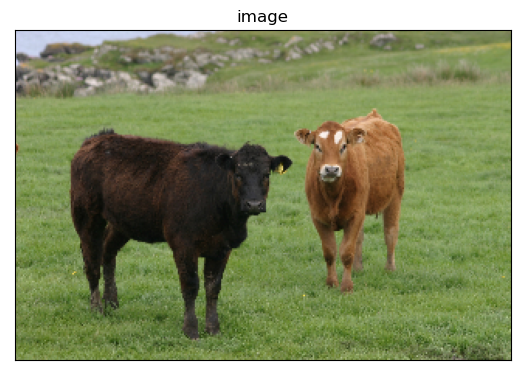

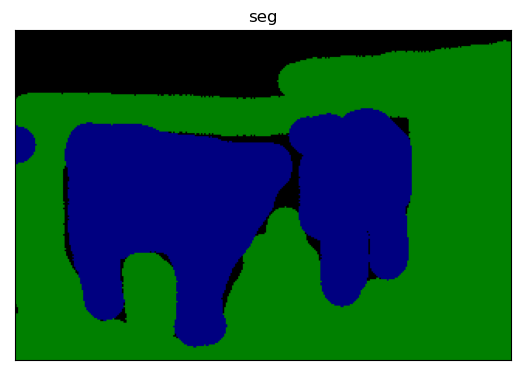

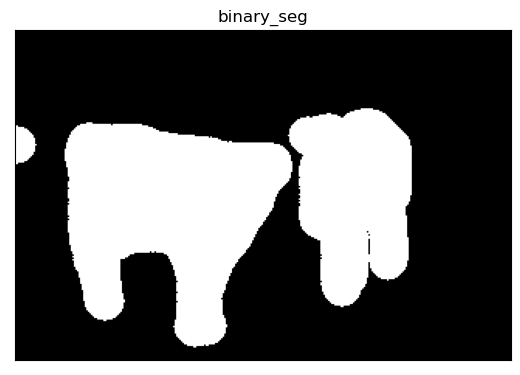

In [ ]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread(dataset_directory + '/train/1_19_s.bmp')
seg_sample = cv2.imread(dataset_directory + '/train/1_19_s_GT.bmp')
print(type(seg_sample))
print(seg_sample.shape)
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')
plot_image(get_binary_seg(seg_sample), 'binary_seg')

Here we provide you with a Dataset and dataloaders.

---



In [ ]:
class SegmentationData(data.Dataset):
    #168:48:24 split
    def __init__(self, img_transform, mask_transform, mode='train'):
        if mode not in ['train','test','val']:
            raise ValueError('Invalid Split %s' % mode)
        self.mode = mode
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.img_list_train_val = [x.split('.')[-2].split('/')[-1][:-3] for x in glob.glob(dataset_directory+'/train/*') if 'GT' in x]
        self.img_list_train_val.sort()
        self.img_list_test = [x.split('.')[-2].split('/')[-1] for x in glob.glob(dataset_directory+'/test/*')]
        self.img_list_test.sort()

        self.x={}
        self.y={}
        self.x['train'] = ['%s/%s.bmp' %(dataset_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.y['train'] = ['%s/%s_GT.bmp' %(dataset_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.x['val'] = ['%s/%s.bmp' %(dataset_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.y['val'] = ['%s/%s_GT.bmp' %(dataset_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.x['test'] = ['%s/%s.bmp' %(dataset_directory+'/test',x) for x in self.img_list_test]

    def __len__(self):
        return len(self.x[self.mode])

    def __getitem__(self, index):
      if self.mode in ['train', 'val']:
          img = Image.open(self.x[self.mode][index]).convert('RGB')
          mask = get_binary_seg(np.array(Image.open(self.y[self.mode][index]).convert('RGB')))#.astype(np.int)
          mask = np.squeeze(mask.astype(np.uint8), axis=2)*255
          mask = Image.fromarray(mask)
          tensor_img = self.img_transform(img)
          tensor_mask = self.mask_transform(mask)
          return tensor_img,tensor_mask
      else:
          img = Image.open(self.x[self.mode][index]).convert('RGB')
          tensor_img = self.img_transform(img)
          return tensor_img


img_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
mask_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='train')
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='val')
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)
test_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)

For convenience, here's an example of how to use these dataloaders.

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
<class 'torch.Tensor'>
torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
torch.Size([16, 3, 256, 256])


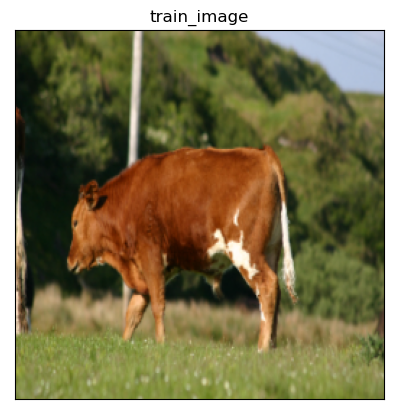

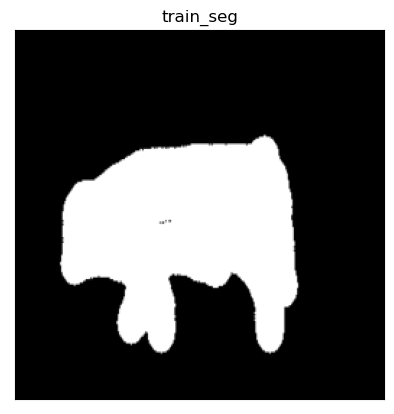

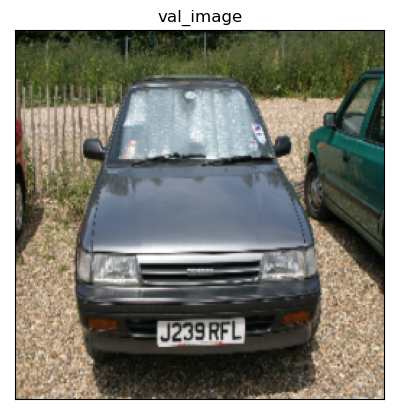

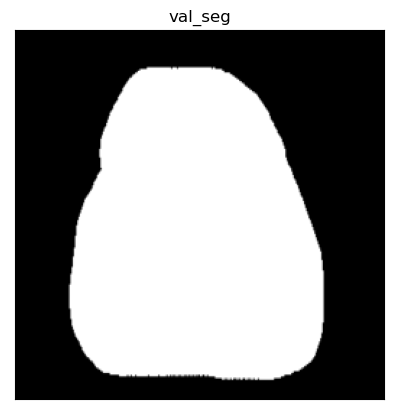

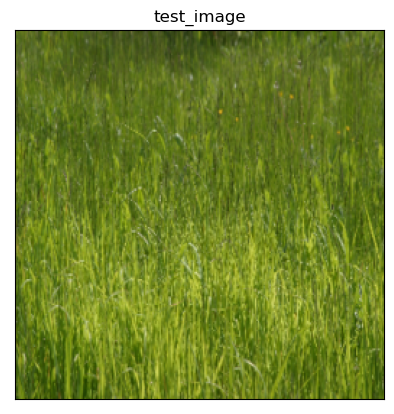

In [ ]:
input,labels = next(iter(train_dataloader))
print(input.shape,labels.shape)
print(type(input[2]))
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'train_image', cv2=False)
plot_image(mask, 'train_seg')

input,labels = next(iter(val_dataloader))
print(input.shape,labels.shape)
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'val_image', cv2=False)
plot_image(mask, 'val_seg')

input = next(iter(test_dataloader))
print(input.shape)
img = input[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'test_image', cv2=False)

## 1. Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to perform these segmentations, where we need to distinguish foreground from background, where the class of interest is considered foreground.

###  U-Net

<img src="https://www.researchgate.net/profile/Alan-Jackson-2/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png" style="width:650px;height:400px;">

A U-Net is an end-to-end segmentation network that should work reasonably well in this low data setting. It will take an image, progressively convolve it to a collection of many small feature maps, and then progressively up-convolve the maps while combining with crops from the previous layers. The figure provided gives an excellent example of a baseline U-Net that you can use as a starting point.

For these operations, use ```nn.Conv2d```, ```torch.cat```, and ```nn.ConvTranspose2d```, ```nn.MaxPool2d```. You may find it useful to use ```nn.BatchNorm2d``` as well.

Note that you can experiment with different channel sizes. Try to start with something smaller than 112, like 16.

Let's now implement those the model!

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    self.conv1 = self.DoubleConv(3, 32)
    self.conv2 = self.DoubleConv(32, 64)
    self.conv3 = self.DoubleConv(64, 128)
    self.conv4 = self.DoubleConv(128, 256)

    self.conv5 = self.DoubleConv(256,256)
    self.upconv5 = torch.nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
    self.conv6 = self.DoubleConv(512,128)
    self.upconv6 = torch.nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
    self.conv7 = self.DoubleConv(256,64)
    self.upconv7 = torch.nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
    self.conv8 = self.DoubleConv(128,32)
    self.upconv8 = torch.nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.conv9 = self.DoubleConv(64,32)

    self.dropout = nn.Dropout(p=0.5)
    self.maxpool = nn.MaxPool2d(2, 2)
    self.output = nn.Conv2d(32,1, kernel_size=1)
    self.sigmoid = nn.Sigmoid()

  def DoubleConv(self, in_channels, out_channels, kernel_size=3, padding=1):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
    )
  
  def forward(self, input):

    x1 = self.conv1(input)
    x1_max = self.maxpool(x1)
    x2 = self.conv2(x1_max)
    x2_max = self.maxpool(x2)
    x3 = self.conv3(x2_max)
    x3_max = self.maxpool(x3)
    x4 = self.conv4(x3_max)
    x4_max = self.maxpool(x4)

    x5 = self.conv5(x4_max)
    x5 = self.upconv5(x5)
    x5 = torch.cat([x5, x4], 1)
    x5 = self.dropout(x5)

    x6 = self.conv6(x5)
    x6 = self.upconv6(x6)
    x6 = torch.cat([x6, x3], 1)
    x6 = self.dropout(x6)
    
    x7 = self.conv7(x6)
    x7 = self.upconv7(x7)
    x7 = torch.cat([x7, x2], 1)
    x7 = self.dropout(x7)
    
    x8 = self.conv8(x7)
    x8 = self.upconv8(x8)
    x8 = torch.cat([x8, x1], 1)
    x8 = self.dropout(x8)
    
    x9 = self.conv9(x8)
    out = self.output(x9)
    out = self.sigmoid(out)
    return out

## 2. Defining the for loop for train and validation phase

### In each the phases certain things one has to be careful of:

- Training Phase:
  - Make sure the model is in train mode. That is ensured by `model.train()`

  - While looping over instances of a batch, make sure the graidents are always set to zero before calling the backward function. That's done by `optim.zero_grad()`. If this is not done, the gradients get accumulated.

  - Call the backward function on the loss by `loss.backward()` so that the loss get back propagated.

  - Call the step function of the optimiser to update the weights of the network. This is done by `optim.step()`

- Validation/Testing Phase
  - Make sure your model is in eval mode. This makes the model deterministic rather than probabilistic. This is ensured by `model.eval()`
  - As we don't need any gradients doing our validation/ testing phase, we can esnure that they are not calculated by defining a block with `torch.no_grad()`

In [ ]:
# Select GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 0:
  print('Using', torch.cuda.device_count(),torch.cuda.get_device_name(0), 'GPU.')
  model = nn.DataParallel(model)
model.to(device)

# Training & Validation loops
num_epochs = 50
batch_size = 16 
learning_rate = 0.0001

model = UNet()
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 


train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
  model.train()
  train_loss = []
  val_loss = []
  train_acc = 0.
  acc_labels, total_labels = 0., 0.
  val_acc = 0.
  val_acc_labels, val_total_labels = 0., 0.

  # Training
  for idx, (input, labels) in enumerate(train_dataloader):
    input = input.to(device)
    labels = labels.to(device)
    outputs = model(input)
    
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    predictions = (outputs > 0.5).float()
    true_predictions = (predictions == labels).float().sum()
    acc_labels += true_predictions.item() 
    total_labels += labels.numel()
  
  train_acc += acc_labels / total_labels
  train_acc_list.append(train_acc)
  train_loss = np.mean(train_loss)
  train_loss_list.append(train_loss)

  # Validation
  model.eval()
  for idx, (input, labels) in enumerate(val_dataloader):
    with torch.no_grad():
      input = input.to(device)
      labels = labels.to(device)

      outputs = model(input)
      
      loss = criterion(outputs, labels)

      val_loss.append(loss.item())

      predictions = (outputs > 0.5).float()
      true_predictions = (predictions == labels).float().sum()
      val_acc_labels += true_predictions.item() 
      val_total_labels += labels.numel()

  val_acc += val_acc_labels / val_total_labels
  val_acc_list.append(val_acc)
  val_loss = np.mean(val_loss)
  val_loss_list.append(val_loss)

  print("Epoch : {}, Train loss: {} , Train Acc: {}, Val loss: {}, Val acc: {}".format(epoch, train_loss, train_acc, val_loss, val_acc))

Using 1 Tesla P100-PCIE-16GB GPU.
Epoch : 0, Train loss: 0.6826677430759777 , Train Acc: 0.5408267066592262, Val loss: 0.6848018765449524, Val acc: 0.5554889043172201
Epoch : 1, Train loss: 0.6278550082987006 , Train Acc: 0.6746008736746651, Val loss: 0.6788846453030905, Val acc: 0.5946229298909506
Epoch : 2, Train loss: 0.5690773021091114 , Train Acc: 0.7467351640973773, Val loss: 0.662128766377767, Val acc: 0.5789165496826172
Epoch : 3, Train loss: 0.5166307362643155 , Train Acc: 0.783350354149228, Val loss: 0.6401529113451639, Val acc: 0.6202116012573242
Epoch : 4, Train loss: 0.4773230363022197 , Train Acc: 0.8061942145937965, Val loss: 0.6173605918884277, Val acc: 0.6507047017415365
Epoch : 5, Train loss: 0.4348283193328164 , Train Acc: 0.838225591750372, Val loss: 0.7378375927607218, Val acc: 0.640406608581543
Epoch : 6, Train loss: 0.40829604864120483 , Train Acc: 0.8560069856189546, Val loss: 0.6653282841046652, Val acc: 0.5802218119303385
Epoch : 7, Train loss: 0.4098040326075

## 3. Challenge Submission
Evaluate on the test set, and save the resulting segmentations in the same format as those in the initial dataset. 
Your challenge results should be saved in a torch file with the same format as in A3, with shape (24, 256, 256), where all values are either 1 (foreground) or 0 (background).

In [ ]:
# Evaluation
model.eval()
test_predictions = []
for i, (input) in enumerate(test_dataloader):
    with torch.no_grad():
        input = input.to(device)
        outputs = model(input)
    outputs = (outputs > 0.5).float()
    test_predictions.append(outputs)

test_predictions = torch.cat(test_predictions, dim=0)   
test_predictions = np.squeeze(test_predictions, axis=1)

# Save predictions
torch.save(test_predictions, '12uranium98.pth')

Use this code to check your submission file:

In [ ]:
masks = torch.load('12uranium98.pth')

assert(masks.shape == (24, 256, 256))
assert((torch.where(masks == 1, 10, 0).sum() + torch.where(masks == 0, 10, 0).sum()).item() == 24 * 256 * 256 * 10)

## Analysis



### 4. Plot training and validation loss per batch

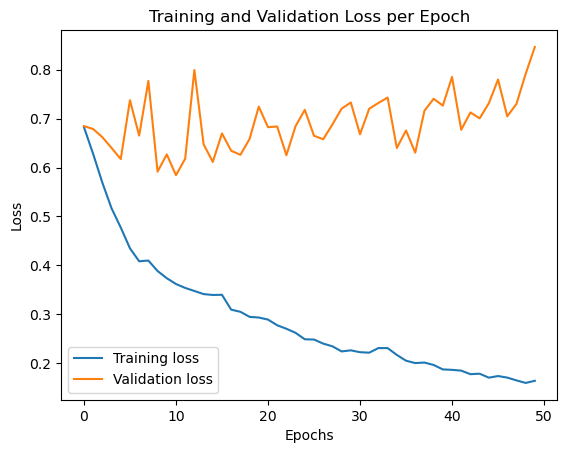

In [ ]:
plt.plot(train_loss_list, label='Training loss')
plt.plot(val_loss_list, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

### 5. Plot training and validation per-pixel accuracy per epoch

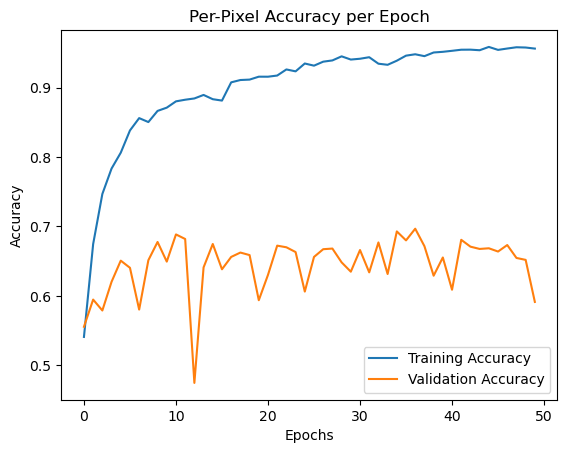

In [ ]:
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Per-Pixel Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 6. Show segmentation result for 3 test images



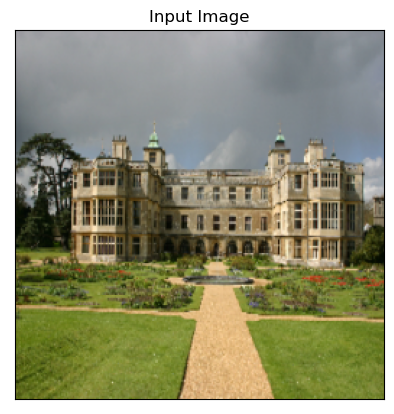

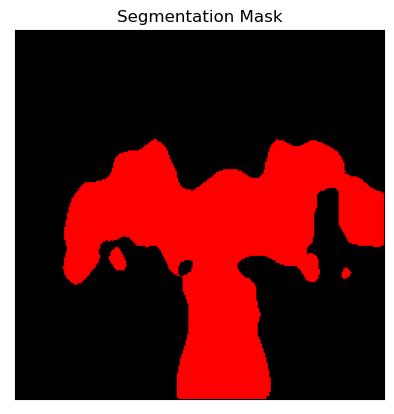

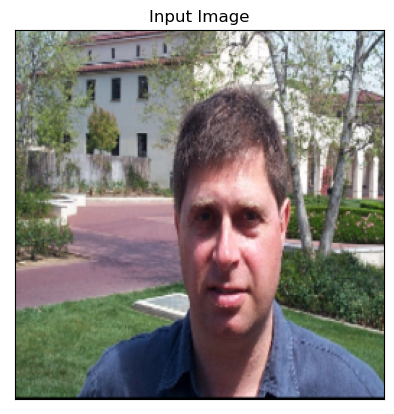

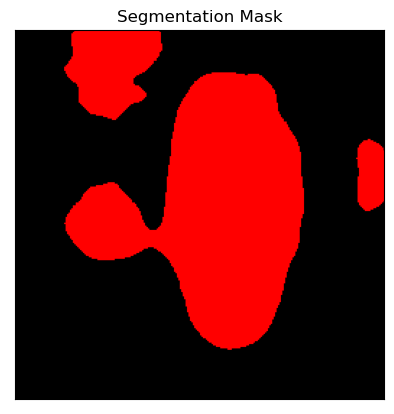

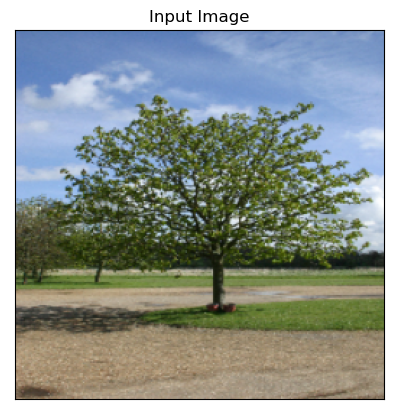

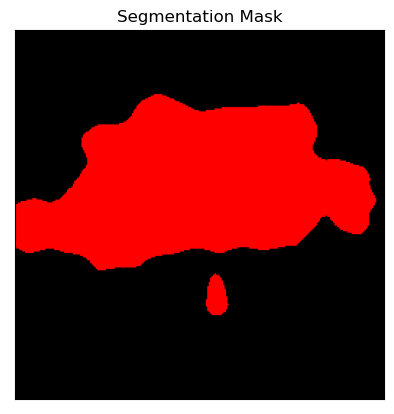

In [ ]:
model.eval()
samples = random.sample(range(len(test_dataloader.dataset)), 3)

for i, idx in enumerate(samples):
    input = test_dataloader.dataset[idx]
    inputs = input.unsqueeze(0).to(device)
    outputs = model(inputs)
    outputs = (outputs > 0.5).float()

    input_image = inputs[0].permute(1, 2, 0).cpu().numpy()
    output_mask = outputs[0].cpu().numpy()
    seg_mask = np.zeros_like(input_image)
    seg_mask[:, :, 0] = output_mask.astype(np.float32)
    plot_image(input_image*0.5 + 0.5, title='Input Image',cv2=False)
    plot_image(seg_mask, title='Segmentation Mask', cv2=False)
plt.show()